In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
print("=== Fraud Detection: DBSCAN Clustering (Unsupervised) ===")
print("=" * 50)

# STEP 1: Load and Prepare Data
print("\n1. Loading and preparing data...")

df = pd.read_csv('data/processed/cc_cleaned.csv')
print(f"Dataset shape: {df.shape}")

# Use PCA features (already good for clustering)
v_features = [f'V{i}' for i in range(1, 29)]
features_for_dbscan = v_features + ['Amount']

X = df[features_for_dbscan]
y = df['Class']

print(f"Using {len(features_for_dbscan)} features")


=== Fraud Detection: DBSCAN Clustering (Unsupervised) ===

1. Loading and preparing data...
Dataset shape: (281918, 34)
Using 29 features


In [3]:
# STEP 2: Scale Features
print("\n2. Scaling features...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled")

# STEP 3: Reduce Dimensions (optional but helps DBSCAN)
print("\n3. Reducing dimensions with PCA...")

# Keep 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Reduced from {X_scaled.shape[1]} to {X_pca.shape[1]} dimensions (95% variance)")



2. Scaling features...
Features scaled

3. Reducing dimensions with PCA...
Reduced from 29 to 27 dimensions (95% variance)



4. Finding optimal eps parameter...


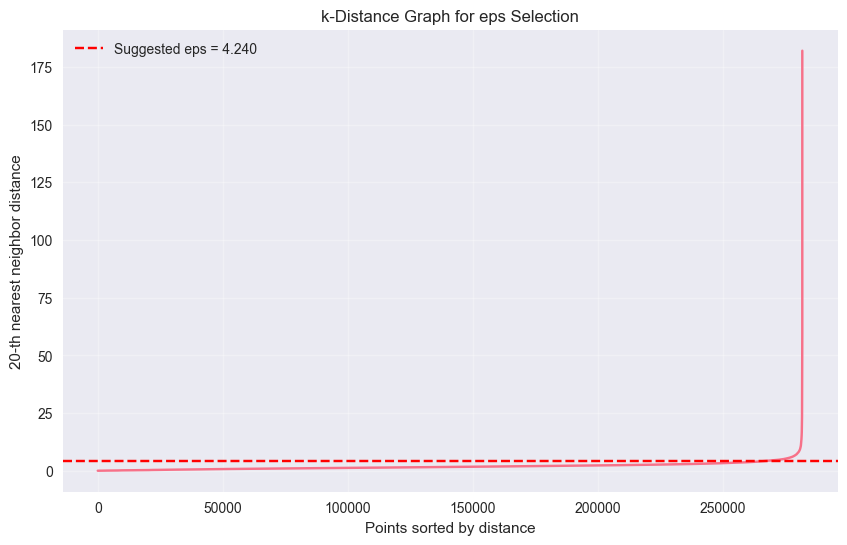

Suggested eps from k-distance graph: 4.240


In [4]:
# STEP 4: Find Optimal eps Parameter
print("\n4. Finding optimal eps parameter...")

# Use k-distance graph to find eps
k = 20  # min_samples * 2
nbrs = NearestNeighbors(n_neighbors=k).fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# Sort distances
k_distances = np.sort(distances[:, k-1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(k_distances)), k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.title('k-Distance Graph for eps Selection')
plt.grid(True, alpha=0.3)

# Suggest eps (knee point)
eps_suggestion = k_distances[int(len(k_distances) * 0.95)]  # 95th percentile
plt.axhline(y=eps_suggestion, color='r', linestyle='--', 
            label=f'Suggested eps = {eps_suggestion:.3f}')
plt.legend()
plt.show()

print(f"Suggested eps from k-distance graph: {eps_suggestion:.3f}")


In [5]:
# STEP 5: Run DBSCAN
print("\n5. Running DBSCAN...")

# Try different parameter combinations
param_combinations = [
    {'eps': 2.0, 'min_samples': 20},
    {'eps': 2.5, 'min_samples': 25},
    {'eps': 3.0, 'min_samples': 30}
]

results = []
for params in param_combinations:
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X_pca)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    results.append({
        'eps': params['eps'],
        'min_samples': params['min_samples'],
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_percent': (n_noise / len(labels)) * 100,
        'labels': labels
    })

# Display results
results_df = pd.DataFrame(results)
print("\nDBSCAN Results:")
print(results_df[['eps', 'min_samples', 'n_clusters', 'n_noise', 'noise_percent']])

# Choose best parameters (aim for 0.5-2% noise for fraud detection)
# First, check if any results fall within the desired noise range
filtered_results = results_df[results_df['noise_percent'].between(0.5, 2)]

if len(filtered_results) > 0:
    # Use the result with the highest number of clusters (or choose another criterion)
    best_result = filtered_results.iloc[0]  # Or filtered_results.loc[filtered_results['n_clusters'].idxmax()]
    print("\n✓ Found parameters within desired noise range (0.5-2%)")
else:
    print("\n⚠ No parameters found within desired noise range (0.5-2%)")
    print("Using alternative selection strategy...")
    
    # Choose result with noise_percent closest to 1%
    results_df['noise_diff'] = abs(results_df['noise_percent'] - 1)
    best_result = results_df.loc[results_df['noise_diff'].idxmin()]
    
eps = best_result['eps']
min_samples = best_result['min_samples']
labels = best_result['labels']

print(f"\nSelected parameters: eps={eps}, min_samples={min_samples}")
print(f"• Clusters found: {best_result['n_clusters']}")
print(f"• Noise points (anomalies): {best_result['n_noise']} ({best_result['noise_percent']:.2f}%)")


5. Running DBSCAN...

DBSCAN Results:
   eps  min_samples  n_clusters  n_noise  noise_percent
0  2.0           20         120    73785      26.172504
1  2.5           25          38    42474      15.066083
2  3.0           30          19    25453       9.028512

⚠ No parameters found within desired noise range (0.5-2%)
Using alternative selection strategy...

Selected parameters: eps=3.0, min_samples=30
• Clusters found: 19
• Noise points (anomalies): 25453 (9.03%)


In [6]:
# STEP 6: Analyze DBSCAN Results
print("\n6. Analyzing DBSCAN results...")

# Add labels to dataframe
df['DBSCAN_Label'] = labels
df['DBSCAN_Anomaly'] = (labels == -1).astype(int)

# Analyze clusters
cluster_stats = []
for cluster_id in sorted(df['DBSCAN_Label'].unique()):
    cluster_data = df[df['DBSCAN_Label'] == cluster_id]
    
    stats = {
        'Cluster': cluster_id,
        'Size': len(cluster_data),
        'Size_Percent': len(cluster_data) / len(df) * 100,
        'Fraud_Count': cluster_data['Class'].sum(),
        'Fraud_Rate': cluster_data['Class'].mean() * 100 if len(cluster_data) > 0 else 0
    }
    cluster_stats.append(stats)

cluster_stats_df = pd.DataFrame(cluster_stats)
print("\nCluster Statistics:")
print(cluster_stats_df.round(2))



6. Analyzing DBSCAN results...

Cluster Statistics:
    Cluster    Size  Size_Percent  Fraud_Count  Fraud_Rate
0        -1   25453          9.03          394        1.55
1         0  192066         68.13           45        0.02
2         1   31764         11.27            2        0.01
3         2   12034          4.27            0        0.00
4         3     296          0.10            0        0.00
5         4    1990          0.71            0        0.00
6         5    1149          0.41            2        0.17
7         6   14157          5.02            5        0.04
8         7     759          0.27            0        0.00
9         8    1109          0.39            0        0.00
10        9     208          0.07            0        0.00
11       10      78          0.03            0        0.00
12       11     178          0.06            0        0.00
13       12      30          0.01            0        0.00
14       13     189          0.07            0        0.00
15 


7. Visualizing DBSCAN results...


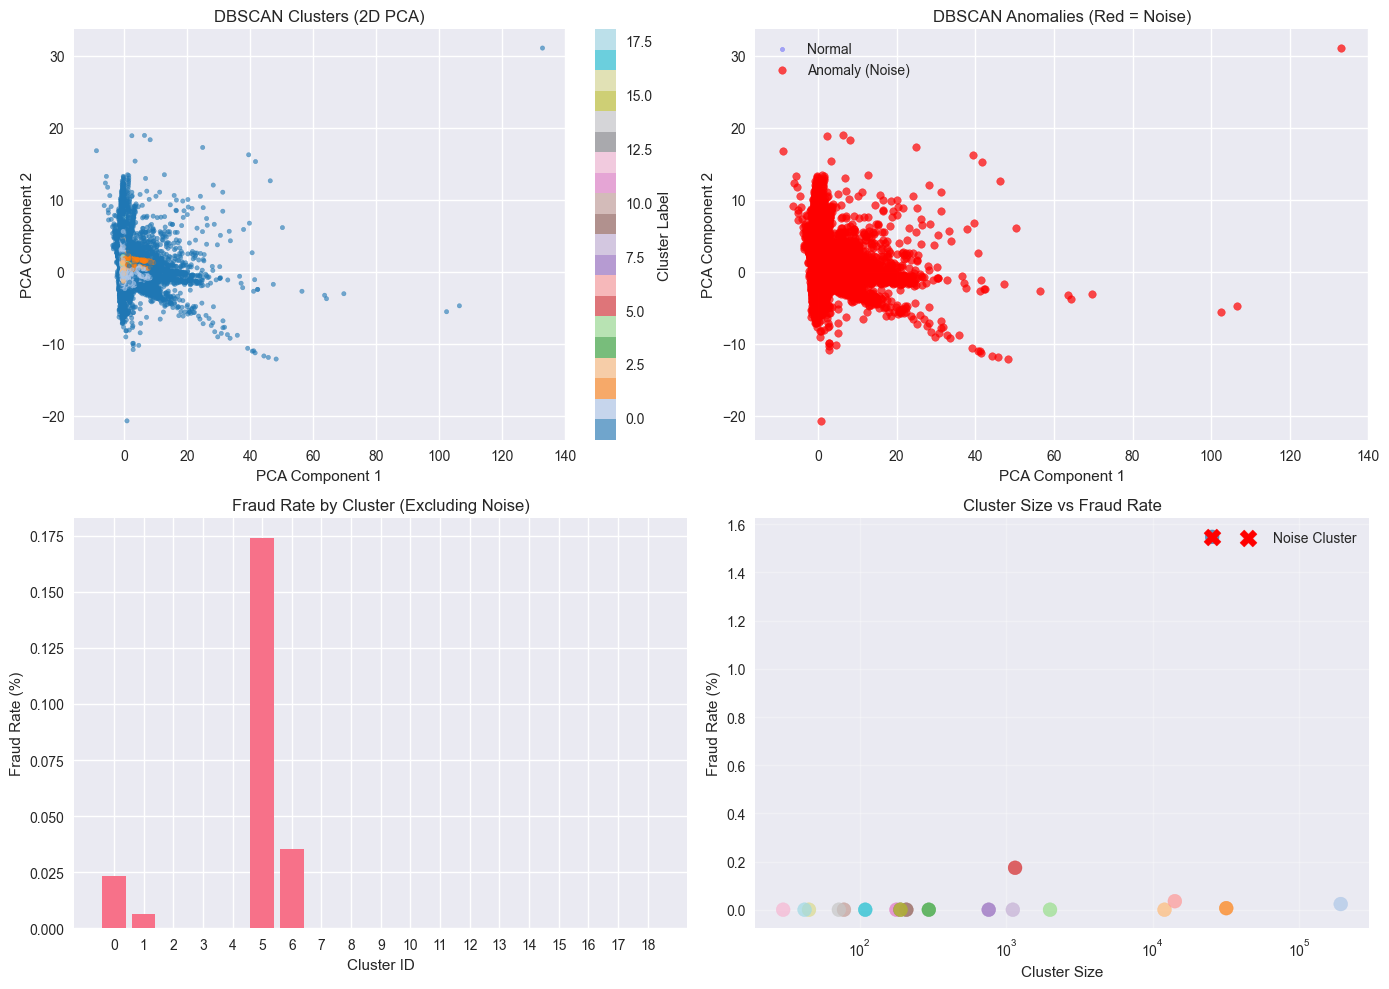

In [7]:
# STEP 7: Visualize Results
print("\n7. Visualizing DBSCAN results...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: 2D PCA with DBSCAN clusters
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_scaled)

scatter = axes[0,0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab20', alpha=0.6, s=10)
axes[0,0].set_xlabel('PCA Component 1')
axes[0,0].set_ylabel('PCA Component 2')
axes[0,0].set_title('DBSCAN Clusters (2D PCA)')
plt.colorbar(scatter, ax=axes[0,0], label='Cluster Label')

# Plot 2: Anomalies (noise points) highlighted
noise_mask = labels == -1
axes[0,1].scatter(X_2d[~noise_mask, 0], X_2d[~noise_mask, 1], 
                  alpha=0.3, s=10, label='Normal', color='blue')
axes[0,1].scatter(X_2d[noise_mask, 0], X_2d[noise_mask, 1], 
                  alpha=0.7, s=30, label='Anomaly (Noise)', color='red')
axes[0,1].set_xlabel('PCA Component 1')
axes[0,1].set_ylabel('PCA Component 2')
axes[0,1].set_title('DBSCAN Anomalies (Red = Noise)')
axes[0,1].legend()

# Plot 3: Fraud distribution in clusters (excluding noise)
clusters_without_noise = cluster_stats_df[cluster_stats_df['Cluster'] != -1]
bars = axes[1,0].bar(range(len(clusters_without_noise)), clusters_without_noise['Fraud_Rate'])
axes[1,0].set_xlabel('Cluster ID')
axes[1,0].set_ylabel('Fraud Rate (%)')
axes[1,0].set_title('Fraud Rate by Cluster (Excluding Noise)')
axes[1,0].set_xticks(range(len(clusters_without_noise)))
axes[1,0].set_xticklabels([f'{int(c)}' for c in clusters_without_noise['Cluster']])

# Plot 4: Size vs Fraud Rate
scatter2 = axes[1,1].scatter(cluster_stats_df['Size'], cluster_stats_df['Fraud_Rate'], 
                             c=cluster_stats_df['Cluster'], cmap='tab20', s=100, alpha=0.7)
axes[1,1].set_xlabel('Cluster Size')
axes[1,1].set_ylabel('Fraud Rate (%)')
axes[1,1].set_title('Cluster Size vs Fraud Rate')
axes[1,1].set_xscale('log')
axes[1,1].grid(True, alpha=0.3)

# Highlight noise cluster
noise_row = cluster_stats_df[cluster_stats_df['Cluster'] == -1]
if len(noise_row) > 0:
    axes[1,1].scatter(noise_row['Size'], noise_row['Fraud_Rate'], 
                      color='red', s=150, marker='X', label='Noise Cluster')
    axes[1,1].legend()

plt.tight_layout()
plt.show()


In [8]:
# STEP 8: Evaluate Anomaly Detection
print("\n8. Evaluating anomaly detection performance...")

# Use DBSCAN noise as fraud prediction
y_pred = (labels == -1).astype(int)

# Confusion matrix
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"DBSCAN Anomaly Detection Performance:")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"\nConfusion Matrix:")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")



8. Evaluating anomaly detection performance...
DBSCAN Anomaly Detection Performance:
Accuracy:  0.9109
Precision: 0.0155
Recall:    0.8795
F1-Score:  0.0304

Confusion Matrix:
True Negatives:  256411
False Positives: 25059
False Negatives: 54
True Positives:  394



9. Comparing with K-Means results...

Comparison: DBSCAN vs K-Means
           Metric    DBSCAN  K-Means
0       Precision    0.0155   0.0152
1          Recall    0.8795   0.0960
2        F1-Score    0.0304   0.0263
3    Anomaly_Rate    9.0285   1.0000
4  True_Positives  394.0000  43.0000


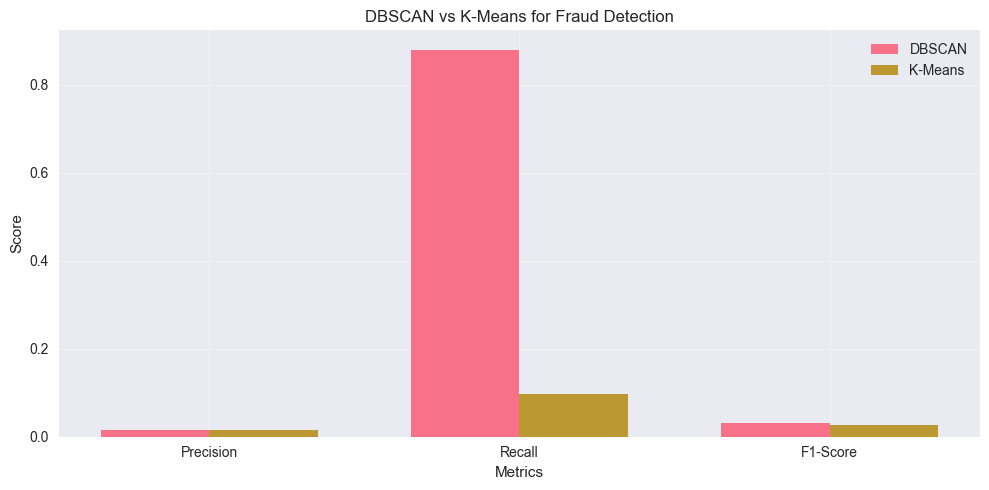

In [9]:
# STEP 9: Compare with K-Means
print("\n9. Comparing with K-Means results...")

try:
    # Load K-Means results
    kmeans_results = pd.read_csv('reports/kmeans_anomaly_results.csv')
    best_kmeans = kmeans_results.loc[kmeans_results['F1_Score'].idxmax()]
    
    comparison = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-Score', 'Anomaly_Rate', 'True_Positives'],
        'DBSCAN': [precision, recall, f1, best_result['noise_percent'], tp],
        'K-Means': [best_kmeans['Precision'], best_kmeans['Recall'], 
                   best_kmeans['F1_Score'], 
                   (1-best_kmeans['Threshold_Percentile'])*100,
                   best_kmeans['True_Positives']]
    })
    
    print("\nComparison: DBSCAN vs K-Means")
    print("=" * 40)
    print(comparison.round(4))
    
    # Visual comparison
    fig, ax = plt.subplots(figsize=(10, 5))
    metrics = ['Precision', 'Recall', 'F1-Score']
    x = np.arange(len(metrics))
    width = 0.35
    
    ax.bar(x - width/2, comparison.loc[:2, 'DBSCAN'], width, label='DBSCAN')
    ax.bar(x + width/2, comparison.loc[:2, 'K-Means'], width, label='K-Means')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('DBSCAN vs K-Means for Fraud Detection')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("⚠ K-Means results not found for comparison")


In [10]:
# STEP 10: Save Results
print("\n10. Saving results...")

import os
import joblib
os.makedirs('models', exist_ok=True)

# Save DBSCAN model and scaler
joblib.dump(dbscan, 'models/dbscan_model.pkl')
joblib.dump(scaler, 'models/dbscan_scaler.pkl')
joblib.dump(pca, 'models/dbscan_pca.pkl')
print("Models saved")

# Save DBSCAN features
df[['DBSCAN_Label', 'DBSCAN_Anomaly', 'Class']].to_csv(
    'data/processed/dbscan_features.csv', index=False)
print("DBSCAN features saved")

# Save performance report
performance_report = {
    'eps': eps,
    'min_samples': min_samples,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'n_clusters': best_result['n_clusters'],
    'n_noise': best_result['n_noise'],
    'noise_percent': best_result['noise_percent'],
    'true_positives': tp,
    'false_positives': fp
}

performance_df = pd.DataFrame([performance_report])
performance_df.to_csv('reports/dbscan_performance.csv', index=False)
print("Performance report saved")


10. Saving results...
Models saved
DBSCAN features saved
Performance report saved


In [11]:
# STEP 11: Final Summary
print("\n" + "="*50)
print("FINAL SUMMARY - DBSCAN")
print("="*50)

print(f"\n DBSCAN RESULTS:")
print(f"• Parameters: eps={eps}, min_samples={min_samples}")
print(f"• Clusters found: {best_result['n_clusters']}")
print(f"• Anomalies detected: {best_result['n_noise']:,} ({best_result['noise_percent']:.2f}%)")

print(f"\n ANOMALY DETECTION:")
print(f"• Precision: {precision:.1%}")
print(f"• Recall: {recall:.1%}")
print(f"• F1-Score: {f1:.4f}")

print(f"\n KEY INSIGHTS:")
print(f"• DBSCAN automatically labels anomalies (noise points)")
print(f"• Density-based approach catches different patterns than K-Means")
print(f"• No need to specify number of clusters")
print(f"• Excellent for finding isolated fraud transactions")

print(f"\nDBSCAN implementation completed!")


FINAL SUMMARY - DBSCAN

 DBSCAN RESULTS:
• Parameters: eps=3.0, min_samples=30
• Clusters found: 19
• Anomalies detected: 25,453 (9.03%)

 ANOMALY DETECTION:
• Precision: 1.5%
• Recall: 87.9%
• F1-Score: 0.0304

 KEY INSIGHTS:
• DBSCAN automatically labels anomalies (noise points)
• Density-based approach catches different patterns than K-Means
• No need to specify number of clusters
• Excellent for finding isolated fraud transactions

DBSCAN implementation completed!
